# SVD

In [1]:
import pandas as pd 
all = pd.read_csv(r"C:\Users\nolle\OneDrive\Documents\Université\M2\Mémoire\Base de données traitées\All.csv")
movies_final = pd.read_csv(r"C:\Users\nolle\OneDrive\Documents\Université\M2\Mémoire\Base de données traitées\movies_final.csv")

In [2]:
all.head()

,userId,movieId,rating,timestamp,genres_x_x,title_bis_x,title_clean_x,date_x,budget_x,overview_x,...,tagline_x,genres_x_y,title_bis_y,title_clean_y,date_y,budget_y,overview_y,release_date_y,revenue_y,tagline_y
0,1,1193,5,978300760,Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,...,"If he's crazy, what does that make you?",Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,1975-11-18,108981275.0,"If he's crazy, what does that make you?"
1,2,1193,5,978298413,Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,...,"If he's crazy, what does that make you?",Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,1975-11-18,108981275.0,"If he's crazy, what does that make you?"
2,12,1193,4,978220179,Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,...,"If he's crazy, what does that make you?",Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,1975-11-18,108981275.0,"If he's crazy, what does that make you?"
3,15,1193,4,978199279,Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,...,"If he's crazy, what does that make you?",Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,1975-11-18,108981275.0,"If he's crazy, what does that make you?"
4,17,1193,5,978158471,Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,...,"If he's crazy, what does that make you?",Drama,One Flew Over the Cuckoo's Nest,One Flew Over the Cuckoo's Nest (1975),1975,3000000,While serving time for insanity at a state men...,1975-11-18,108981275.0,"If he's crazy, what does that make you?"


Code si je souhaite modifier les noms de colonnes :  

In [3]:
# df = df.rename(columns={   
#    'colonne1': 'nouveau_nom1',     
#    'colonne2': 'nouveau_nom2'      
# })

# I. Création de la matrice d'utilité

In [3]:
# On garde uniquement les colonnes utiles
all_util = all[["userId", "title_clean_x", "rating"]]

# Création de la matrice d’utilité avec pivot_table
util_matrix = all_util.pivot_table(index = "userId", 
                                   columns="title_clean_x", 
                                   values="rating")

In [4]:
len(util_matrix)
# 6040 lignes : chaque ligne correspond à un utilisateur

6040

In [5]:
len(util_matrix.columns)
# 2954 films

2954

## Calcul de la sparsity

In [6]:
# Nombre total de cellules (utilisateurs x films)
total_values = util_matrix.shape[0] * util_matrix.shape[1]

# Nombre de notes réelles (non nulles)
non_null_values = util_matrix.count().sum()

# Taux de sparsity
sparsity = 1 - (non_null_values / total_values)
print(f"Taux de sparsity : {sparsity:.2%}")

Taux de sparsity : 94.96%


La sparsity est de 95%, signifiant que 95% des cellules de la matrice d'utilité sont vides, car les utilisateurs 
notent une petite portion des films. Ceci est logique et courant dans un système de recommandations. 

# II. Présentation SVD et approche classique

SVD est une méthode de factorisation de matrice utilisée pour la réduction de dimension et la détection de structures latentes. Dans le contexte des systèmes de recommandation collaboratifs, elle est utilisée pour approximer la matrice d'utilité (utilisateurs × items) en une forme plus compacte.

## Remplacement des notes vides par la moyenne par utilisateur

In [7]:
util_matrix_filled = util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

In [8]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

## Choix du nombre de composantes

Méthode du coude : méthode visuelle utilisée pour choisir le nombre optimal de composantes (ou de clusters, ou dimensions) dans une technique de réduction ou de regroupement, comme SVD.  
Le point où l’amélioration devient marginale forme un "coude". 

Le coude est détecté à : 10 composantes


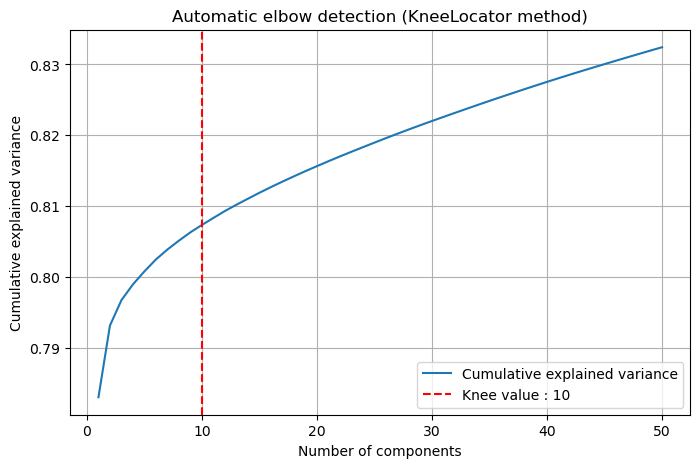

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from kneed import KneeLocator

#Étape 1 : Appliquer SVD
svd = TruncatedSVD(n_components=50)
svd.fit(util_matrix_filled)
explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Étape 2 : Détection automatique du coude
x = range(1, len(explained_variance) + 1)
knee = KneeLocator(x, explained_variance, curve='concave', direction='increasing')

print(f"Le coude est détecté à : {knee.knee} composantes")

# Étape 3 : Visualisation
plt.figure(figsize=(8, 5))
plt.plot(x, explained_variance, label="Cumulative explained variance")
plt.axvline(knee.knee, color='red', linestyle='--', label=f"Knee value : {knee.knee}")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Automatic elbow detection (KneeLocator method)")
plt.grid(True)
plt.legend()
plt.show()

Le package kneed (→ KneeLocator) :
- Prend une série de points x et y (par ex. nombre de composantes vs variance cumulée)
- Analyse la courbure de la fonction
- Cherche l’endroit où la pente diminue le plus brusquement
- Retourne ce point comme étant le "knee"

Nous allons donc conserver 10 composantes

## Application de SVD

In [11]:
svd = TruncatedSVD(n_components=10, random_state=42)

user_factors = svd.fit_transform(util_matrix_filled) # 6040 utilisateurs X 10 composantes

# Étape 3 : Obtenir les composantes (vecteurs latents des items)
item_factors = svd.components_ # 10 lignes X 2954 films

# Étape 4 : Reconstruction de la matrice approximée
approx_matrix = np.dot(user_factors, item_factors)

# Étape 5 (optionnelle) : reconstruire un DataFrame pour mieux visualiser
approx_df = pd.DataFrame(approx_matrix, index=util_matrix.index, columns=util_matrix.columns)

approx_df.head()

title_clean_x,...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1996),12 Angry Men (1957),2 Days in the Valley (1996),20 Dates (1998),"20,000 Leagues Under the Sea (1954)",200 Cigarettes (1999),2001: A Space Odyssey (1968),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),Young Sherlock Holmes (1985),Young and Innocent (1937),Zachariah (1971),Zero Effect (1998),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.227423,4.219395,4.211117,4.221725,4.245857,4.215183,4.216863,4.234052,4.219222,4.223471,...,4.232792,4.224336,4.235984,4.242288,4.225385,4.220644,4.220811,4.219457,4.205524,4.207888
2,3.699238,3.695525,3.679112,3.702531,3.756614,3.660729,3.684913,3.706129,3.691713,3.666243,...,3.737699,3.708497,3.668422,3.739689,3.694741,3.671797,3.696901,3.694963,3.662439,3.628428
3,3.920693,3.910296,3.907890,3.900028,3.935104,3.909399,3.914723,3.938554,3.927391,3.987330,...,3.901333,3.913594,3.981481,3.928239,3.900411,3.916392,3.913141,3.910511,3.898285,3.913302
4,4.250666,4.249104,4.243986,4.241444,4.275322,4.244326,4.245975,4.254232,4.251230,4.286549,...,4.238537,4.251030,4.306941,4.250392,4.252372,4.246311,4.250957,4.249570,4.241019,4.242930
5,3.145633,3.159145,3.098493,3.105985,3.170626,3.147819,3.127253,3.116875,3.124355,3.432448,...,2.972797,3.151828,3.345824,3.023236,3.111151,3.132288,3.159312,3.160824,3.241375,3.217695


## Test du modèle

In [12]:
# Étape 1 : Extraire uniquement les valeurs non-NaN (en format long)
true_values = util_matrix.stack()  # Series indexée par (user, item) avec uniquement les valeurs non manquantes
pred_values = approx_df.stack()

# Étape 2 : Aligner les deux séries
true_values, pred_values = true_values.align(pred_values, join = 'inner')

# Étape 3 : Calcul du RMSE
rmse = np.sqrt(np.mean((true_values - pred_values) ** 2))
print(f"RMSE : {rmse:.4f}")

RMSE : 0.9238


In [ ]:
true_values

userId  title_clean_x                                   
1       A Bug's Life (1998)                                 5.0
        A Christmas Story (1983)                            5.0
        A Close Shave (1995)                                3.0
        Airplane! (1980)                                    4.0
        Aladdin (1992)                                      4.0
                                                           ... 
6040    West Side Story (1961)                              4.0
        When Harry Met Sally... (1989)                      5.0
        Witness (1985)                                      4.0
        Women on the Verge of a Nervous Breakdown (1988)    4.0
        Young Frankenstein (1974)                           4.0
Length: 898688, dtype: float64

In [ ]:
pred_values

userId  title_clean_x                                   
1       A Bug's Life (1998)                                 4.228845
        A Christmas Story (1983)                            4.269920
        A Close Shave (1995)                                4.203578
        Airplane! (1980)                                    4.223617
        Aladdin (1992)                                      4.256946
                                                              ...   
6040    West Side Story (1961)                              3.626886
        When Harry Met Sally... (1989)                      3.345340
        Witness (1985)                                      3.625645
        Women on the Verge of a Nervous Breakdown (1988)    3.562638
        Young Frankenstein (1974)                           3.780059
Length: 898688, dtype: float64

### Comparaison du RMSE avec différents nombres de composantes + explication du problème d'avoir trop de composantes

In [ ]:
components_list = [5, 10, 20, 50, 100, 150]
rmse_scores = []

for k in components_list:
    svd = TruncatedSVD(n_components=k, random_state=42)
    user_factors = svd.fit_transform(util_matrix_filled)
    item_factors = svd.components_
    approx = np.dot(user_factors, item_factors)
    approx_df = pd.DataFrame(approx, index=util_matrix.index, columns=util_matrix.columns)
    
    true_vals, pred_vals = util_matrix.stack(), approx_df.stack()
    true_vals, pred_vals = true_vals.align(pred_vals, join='inner')
    
    rmse = np.sqrt(np.mean((true_vals - pred_vals) ** 2))
    rmse_scores.append((k, rmse))

for k, r in rmse_scores:
    print(f"n_components = {k} → RMSE = {r:.4f}")

n_components = 5 → RMSE = 0.9454
n_components = 10 → RMSE = 0.9238
n_components = 20 → RMSE = 0.8967
n_components = 50 → RMSE = 0.8405
n_components = 100 → RMSE = 0.7677
n_components = 150 → RMSE = 0.7066


In [ ]:
# Tester plusieurs valeurs de composantes
# components_range = [5, 10, 20, 50, 100, 150, 200]
# rmse_list = []

# for k in components_range:
    # svd = TruncatedSVD(n_components=k, random_state=42)
    # user_factors = svd.fit_transform(util_matrix_filled)
    # item_factors = svd.components_
    # approx = np.dot(user_factors, item_factors)
    # approx_df = pd.DataFrame(approx, index=util_matrix.index, columns=util_matrix.columns)
    
    # Comparaison uniquement sur les vraies valeurs
    # y_true, y_pred = util_matrix.stack(), approx_df.stack()
    # y_true, y_pred = y_true.align(y_pred, join='inner')
    
    # rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    # rmse_list.append((k, rmse))

# 3. Visualiser
# ks, rmses = zip(*rmse_list)
# plt.plot(ks, rmses, marker='o')
# plt.xlabel("Nombre de composantes")
# plt.ylabel("RMSE")
# plt.title("RMSE selon le nombre de composantes")
# plt.grid(True)
# plt.show()

# III. Méthode train/test

Dans cette méthode on fait nos prédictions sur 90% du jeu d'entraînement et 10% des notes sont cachées. Ensuite, nous vérifions si ces 10% ont bien été reconstruits par SVD.

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Extraire toutes les notes connues
ratings = all[["userId", "rating", "title_clean_y"]]

# 2. Split en train/test (ex : 90% - 10%)
train_data, test_data = train_test_split(ratings, test_size=0.1, random_state=42)

# 3. Créer une matrice d’utilité pour le train
train_matrix = pd.pivot_table(train_data, index='userId', columns='title_clean_y', values='rating')

# 4. Remplir les NaN (moyenne utilisateur par exemple)
train_matrix_filled = train_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

# 5. Appliquer SVD à 10 composantes
svd = TruncatedSVD(n_components=10, random_state=42)
user_factors = svd.fit_transform(train_matrix_filled)
item_factors = svd.components_

# 6. Recréer la matrice approximée : il s'agit de notre matrice d'entraînement sur laquelle on a fait nos
# prédictions
approx_matrix = np.dot(user_factors, item_factors) # Multiplication de matrice
approx_df = pd.DataFrame(approx_matrix, index=train_matrix.index, columns=train_matrix.columns) # Reconstruction en DF

# 7. Comparer aux vraies notes du test set
y_true, y_pred = [], []

for _, row in test_data.iterrows():
    user, item, true_rating = row['userId'], row['title_clean_y'], row['rating']
    # Parcours des lignes du jeu de données test pour obtenir les vrais notes
    
    if user in approx_df.index and item in approx_df.columns: 
        # Condition pour comparer uniquement aux données du test
        pred_rating = approx_df.loc[user, item] # Localisation de la prédiction

        y_true.append(true_rating) # Remplissage des listes
        y_pred.append(pred_rating)

# 8. Calcul du RMSE
rmse = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))
print(f"RMSE sur le test set : {rmse:.4f}")

RMSE sur le test set : 0.9551


### Méthode train/test avec différent nombre de composantes

Test de n_components = 10
→ RMSE = 0.9551
Test de n_components = 50
→ RMSE = 0.9519
Test de n_components = 100
→ RMSE = 0.9626
Test de n_components = 150
→ RMSE = 0.9739
Test de n_components = 200
→ RMSE = 0.9826


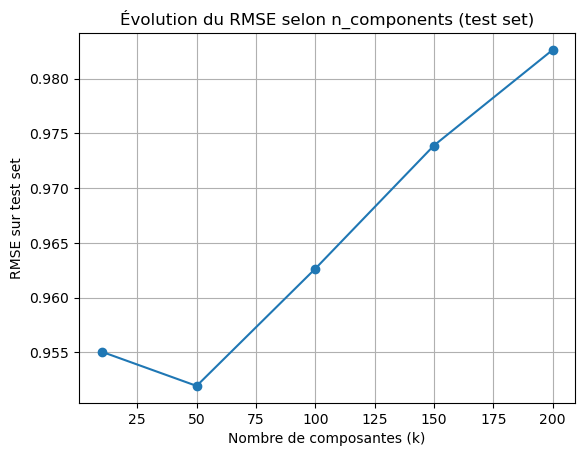

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

rmse_results = []
components_list = [10, 50, 100, 150, 200]

for k in components_list:
    print(f"Test de n_components = {k}")
    
    # Étape 1 : recréer matrice train
    train_matrix = pd.pivot_table(train_data, index='userId', columns='title_clean_y', values='rating')
    
    # Étape 2 : remplissage des NaN (moyenne par utilisateur)
    train_filled = train_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
    
    # Étape 3 : SVD
    svd = TruncatedSVD(n_components=k, random_state=42)
    user_factors = svd.fit_transform(train_filled)
    item_factors = svd.components_
    
    # Étape 4 : reconstruction de la matrice approximée
    approx_matrix = np.dot(user_factors, item_factors)
    approx_df = pd.DataFrame(approx_matrix, index=train_filled.index, columns=train_filled.columns)
    
    # Étape 5 : Évaluation sur le test set
    y_true, y_pred = [], []
    for _, row in test_data.iterrows():
        user, item, true_rating = row['userId'], row['title_clean_y'], row['rating']
        if user in approx_df.index and item in approx_df.columns:
            pred_rating = approx_df.loc[user, item]
            y_true.append(true_rating)
            y_pred.append(pred_rating)

    # Étape 6 : Calcul du RMSE
    if y_true:  # vérifie qu'on a bien des valeurs valides
        rmse = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))
        rmse_results.append((k, rmse))
        print(f"→ RMSE = {rmse:.4f}")
    else:
        print(f"⚠️ Aucune prédiction possible pour n_components={k}")

# Étape 7 : Graphique
ks, rmses = zip(*rmse_results)
plt.plot(ks, rmses, marker='o')
plt.xlabel("Nombre de composantes (k)")
plt.ylabel("RMSE sur test set")
plt.title("Évolution du RMSE selon n_components (test set)")
plt.grid(True)
plt.show()

# IV. Cross-validation

In [ ]:
util_matrix_filled = util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

pandas.core.frame.DataFrame

In [22]:
# cellules_non_vides = []

# for idx in util_matrix.index :
    # for col in util_matrix.columns :
        # if pd.notna(util_matrix.loc[idx, col]) :
            # cellules_non_vides.append((idx, col))
    

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Paramètres
n_splits = 5
n_components = 10

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

rmse_scores = []
mae_scores = []

# Matrices de base
X_filled = util_matrix_filled  # matrice remplie
X_original = util_matrix       # matrice d'origine (avec NaN)

# Nouvelle matrice pour stocker toutes les prédictions
final_predictions = pd.DataFrame(index=X_original.index, columns=X_original.columns)

for train_index, test_index in kf.split(X_filled):
    X_train, X_test = X_filled.iloc[train_index], X_filled.iloc[test_index]
    X_test_original = X_original.iloc[test_index]
    
    # SVD sur X_train
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(X_train)
    
    # Reconstruction
    X_test_reconstructed = svd.transform(X_test) @ svd.components_
    X_test_reconstructed = pd.DataFrame(X_test_reconstructed, index=X_test.index, columns=X_test.columns)
    
    # Ici on stocke TOUTES les prédictions du fold et à la fin on aura TOUT
    final_predictions.loc[X_test.index, X_test.columns] = X_test_reconstructed
    
    # Maintenant RMSE uniquement sur les vraies notes :
    true_ratings = []
    predicted_ratings = []
    
    for i in X_test.index:
        for j in X_test.columns:
            if pd.notna(X_test_original.loc[i, j]):  # uniquement où il y avait une vraie note
                true_ratings.append(X_test_original.loc[i, j])
                predicted_ratings.append(X_test_reconstructed.loc[i, j])
    
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    rmse_scores.append(rmse)
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    mae_scores.append(mae)

RMSE moyen sur 5 folds : 0.9319
RMSE sur toutes les notes : 0.2152539361384825


In [ ]:
# Résultat final
print(f"RMSE moyen sur {n_splits} folds : {np.mean(rmse_scores):.4f}")
print(f"RMSE sur toutes les notes : {np.sqrt(mean_squared_error(util_matrix_filled, final_predictions))}")
print(f"MAE moyen sur {n_splits} folds : {np.mean(mae_scores):.4f}")

RMSE moyen sur 5 folds : 0.9319
RMSE sur toutes les notes : 0.2152539361384825
MAE moyen sur 5 folds : 0.7351


In [ ]:
true_all = X_original.stack()         # Uniquement les vraies notes (valeurs non NaN)
pred_all = final_predictions.stack()  # Prédictions à ces mêmes positions

### Export vers CSV pour interface Power BI/Power apps

In [24]:
# final_predictions_export = pd.DataFrame(index= final_predictions.index, 
                                        # columns= final_predictions.columns)

# for i in final_predictions_export.index : 
    # for j in final_predictions_export.columns : 
        # if pd.isna(util_matrix.loc[i,j]) : 
            # final_predictions_export.loc[i,j] = final_predictions.loc[i,j]
        # else : 
            # final_predictions_export.loc[i,j] = None

# final_predictions_export

In [25]:
# Autre possibilité : 
# final_predictions_export = final_predictions.where(util_matrix.isna(), None) 
# --> On garde les prédictions quand le film est NA dans util_matrix, sinon c'est None
# --> Other est la valeur prise si la condition est true

# final_predictions_export = final_predictions.mask(util_matrix.notna(), other = "Masqué")
# Other est la valeur prise si la condition est true

In [26]:
 # On garde uniquement les films non notés dans util_matrix
final_predictions_export = final_predictions.mask(util_matrix.notna(), None)

# Remettre userId comme colonne normale
final_predictions_export_reset = final_predictions_export.reset_index()

# Puis faire le melt
final_predictions_long = final_predictions_export_reset.melt(
    id_vars='userId',
    var_name='film',
    value_name='rating'
)

In [27]:
final_predictions_long.head(10)

,userId,film,rating
0,1,...And Justice for All (1979),4.226671
1,2,...And Justice for All (1979),3.704995
2,3,...And Justice for All (1979),3.921291
3,4,...And Justice for All (1979),4.251607
4,5,...And Justice for All (1979),3.140713
5,6,...And Justice for All (1979),3.914393
6,7,...And Justice for All (1979),4.314227
7,8,...And Justice for All (1979),3.85275
8,9,...And Justice for All (1979),3.734518
9,10,...And Justice for All (1979),4.116466


In [28]:
# final_predictions_long.to_csv(r"C:\Users\nolle\OneDrive\Documents\Université\M2\Mémoire\Méthodes\Prédictions SVD.csv")